<div style="background-color: #28a745 !important; color: white; min-height: 50px; padding: 10px; margin: auto;">
    <p style="text-align: right; font-style: italic">STMKGxHMGI Long Course</p>
    <h1>Sesi: Penentuan Hiposenter Pendekatan Probabilistik</h1>
</div>
<div style="background-color: whitesmoke; padding: 10px ">
    <ul>
        <li>Tujuan: Memperkenalkan sekilas dasar dan implementasi perhitungan hiposenter dengan pendekatan probabilistik</li>
        <li>Keluaran: Peserta dapat memahami dasar secara sekilas kemudian mengimplementasikan dalam Python</li>
        <li>Sesi Materi</li>
        <li>Waktu/Tempat: Sabtu, 25 September 2021/ Zoom</li>
    </ul>
</div>

## Penentuan Hiposenter Pendekatan Probabilistik

*Materi diadopsi dari: Igel, H., Geßele K., Seismic Inverse Problems: Probabilistic estimation of earthquake hypocenters, https://krischer.github.io/seismo_live_build/html/Seismic%20Inverse%20Problems/Earthquake%20Location/el_hypocenter_solution_wrapper.html*

Sebelumnya kita sudah menghitung hiposenter dengan pendekatan analitik melalui linearisasi dengan bantuan deret Taylor, di bagian ini kita akan mengaplikasikan pendekatan probabilistik yang diperkenalkan oleh Albert Tarantola. Dalam pendekatan probabilistik, model dan data diwakilkan sebagai sebuah Probabilty Density Function (PDF). Dengan kata lain, model atau hasil akhir merupakan kumpulan solusi dengan nilai probabilitas tertentu, sehingga dalam menebak solusi pun kita bisa menggunakan banyak nilai.

Sama seperti pada pendekatan analitik, data observasi kita adalah waktu tiba gelombang P yang bisa dituliskan $\mathbf{d_{obs}}=\{t_1,t_2,t_3,t_4\}$. Pada kasus ini kita akan menggunakan ruang 2D dengan sumbu lateral $X$ dan sumbu vertikal $Z$. Karena model yang akan kita cari adalah hiposenter dan origin time maka bisa kita tuliskan sebagai $\mathbf{m}=\{X,Z,T\}$. Dengan kasus 2D ini persamaan maju dapat kita tuliskan sebagai:

$$t_i=f_i(X,Z,T)=T+\frac{\sqrt{(X-x_i)^2-(Z-z_i)^2}}{v}$$

Solusi dalam bentuk PDF kita sebut sebagai *marginal posteriori probability* yang disimbolkan $\sigma_m(X,Z,T)$:

$$
\sigma_m(X,Z,T) = k \; \rho_m(X,Z,T) \; \rho_d(t_1,t_2,t_3,t_4)\rvert_{t_i = f_i(X,Z,T)}
$$

dengan tebakan-tebakan dalam PDF disebut sebagai *a priori information* yang disimbolkan $\rho_m(X,Z,T)$ dan $\rho_d(t_1,t_2,t_3,t_4)$ merupakan *information on the observation* yang dapat ditulis sebagai:

$$
\rho_d(\mathbf{d}) = 
k\exp\Big(-\frac{1}{2} \sum_{i}\big(\frac{t_i - t_i^{obs}}{\sigma_i}\big)^2\Big)
$$ 

$\mathbf{\sigma}$ ={$\sigma_1, \sigma_2, \sigma_3,\sigma_4$} merupakan varians yang menjelaskan ketidakpastian Gaussian dan $k$ merupakan nilai normalisasi.

Dalam contoh ini tebak-tebakan kita wakili dalam distribusi uniform dengan batas kiri dan kanan tertentu.

### Membuat data sintetik

Kita akan menggunakan data sintetik sendiri berupa 4 stasiun dengan masing-masing koordinatnya, nilai ketidakpastian observasi waktu tiba, hiposenter, origin time, dan nilai kecepatan:

In [1]:
import numpy as np

# Koordinat stasiun                      # (original values)
station_x = np.array([ 5,10,15,25])      # x(km) = [ 5,10,15,25]
station_z = np.array([ 0, 0, 0, 0])      # z(km) = [ 0, 0, 0, 0]

# Ketidakpastian waktu tiba hasil picking
uncertain_t = np.array([.5, .2, .4, .2]) # ketidakpastian (s) = [.5,.2,.4,.2]

# Hiposenter, origin time, dan kecepatan gelombang P
source_x = 16                            # hiposenter x (km) = 16
source_z = 15                            # hiposenter z (km)= 15
origin_T = 17                            # origin time (s) = 17
v_exact  =  5                            # kecepatan gel P (km/s) = 5

Selanjutnya dengan persamaan maju kita dapat mendapatkan data waktu tiba sintetik:

In [2]:
# Menghitung data waktu tiba sintetik
t_obs = np.zeros(np.size(station_x))
for i in range(0,np.size(station_x)):  # loop terhadap stasiun
    t_obs[i] = origin_T + 1./v_exact * np.sqrt((station_x[i]-source_x)**2 + \
                                               (station_z[i]-source_z)**2)
print(t_obs)

[20.72021505 20.23109888 20.00665928 20.49857114]


### Membuat ruang model eksplorasi

Seperti yang kita jelaskan di atas bahwa kita dapat menebak dengan banyak nilai dengan jangkauan tertentu. Titik-titik tebakan di ruang model ini akan disampling satu persatu. Karena distribusi yang digunakan adalah uniform maka bisa kita sederhanakan dengan `numpy.arange` dengan setiap nilai memiliki probabilitas sama (dalam kasus ini diwakili nilai 1 dalam `np.ones` untuk mempermudah):

In [3]:
# Ruang model untuk dieksplorasi: (batas bawah, batas atas, lompatan)
space_x = np.arange( 0, 35, 1 )          # koordinat x (km): ( 0, 35, 0.5 )
space_z = np.arange( 0, 25, 1 )          # koordinat z (km): ( 0, 25, 0.5 )
space_T = np.arange(10, 30, 0.5)         # origin time (km): (10, 30, 0.25)

Pada contoh di atas kita akan menebak koordinat x hiposenter dari 0 sampai 34 dengan lompatan 1 (0,1,2,3,....,34), koordinat z hiposenter dari 0 sampai 24 dengan lompatan 1 (0,1,2,3,.....,24), serta origin time dari 10 sampai 30 dengan lompatan 0,5 (10,10.5,11.0,.....,33.5). Totak titik ruang model yang menjadi tebakan dapat kita hitung dengan mengalikan 35, 25, dengan 40 yaitu 35000. Ruang model yang akan dieksplorasi untuk hiposenter (`space_x`, dan `space_z`) dapat kita gambarkan dengan bantuan `np.meshgrid`:

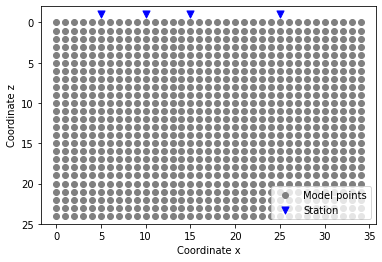

In [4]:
import matplotlib.pyplot as plt

space_x_grd, space_z_grd = np.meshgrid(space_x, space_z)

plt.scatter(space_x_grd, space_z_grd,color="grey", label="Model points")
plt.ylim(max(space_z)+1,-2)
plt.scatter(station_x,station_z-1,marker="v",\
            color="blue",s=50, label="Station")
plt.xlabel("Coordinate x")
plt.ylabel("Coordinate z")
plt.legend(loc="lower right")
plt.show()

Jika ingin memvisualisasikan juga untuk origin time kita bisa memanfaatkan proyeksi 3D:

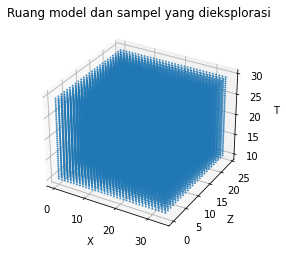

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

space_x_grd, space_z_grd, space_T_grd = np.meshgrid(space_x, space_z, space_T)

ax.scatter(space_x_grd, space_z_grd, space_T_grd, alpha=.7, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('T')


plt.title("Ruang model dan sampel yang dieksplorasi")
plt.show()

### Menyelesaikan inversi hiposenter

Kita akan menghitung waktu tiba untuk masing-masing titik tebakan di ruang model ($X,Z,T$) dengan menggunakan `for` *loop*. Setiap titik yang dikalkulasi akan dihitung nilai *information on the observation*nya ($\rho_d$):

In [6]:
from tqdm import tqdm #hanya untuk menampilkan loading bar

# Solusi inversi hiposenter probabilistik
# Membuat matriks seukuran titik-titik ruang model eksplorasi dengan isi 1
sigM = np.ones([space_x.size, space_z.size, space_T.size]) # Inisiasi PDF posterior
# Loop pada ruang model
for ix,X in enumerate(tqdm(space_x)): #aplikasikan tqdm agar keluar loading bar
    for iz,Z in enumerate(space_z):
        for it,T in enumerate(space_T):
            for istat in range(np.size(station_x)):   # Loop stasiun
                    
                # Pemodelan maju (forward modelling)
                t_calc = T + 1/v_exact * np.sqrt((X-station_x[istat])**2 + (Z-station_z[istat])**2)
                    
                # Menghitung probabilitas tiap titik model
                sigM[ix,iz,it] *= np.exp( -(t_calc-t_obs[istat])**2 / (2*uncertain_t[istat]**2))
                

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.28it/s]


### Menghitung *marginal a posteriori probability*

Kita sudah mendapatkan probabilitas untuk setiap titik di ruang model yang dieksplorasi.Selanjutnya kita dapat menghitung *posterior PDF* dengan cara menjulahkan setiap *axis* dan menormalisasinya:

In [7]:
# Menghitung marginal a posteriori probability untuk nilai x dan z
# dan masing-masing untuk x dan z
sigMxz = np.zeros([space_x.size, space_z.size])
sigMz = np.zeros([space_z.size])
sigMx = np.zeros([space_x.size])
for ix in range(space_x.size):
    sigMx[ix] = np.sum(sigM[ix, :, :])
    for iz in range(space_z.size):
        sigMz[iz] = np.sum(sigM[:, iz, :])
        sigMxz[ix,iz] = np.sum(sigM[ix, iz, :])
sigMx /= np.sum(sigMx)
sigMz /= np.sum(sigMz)

# Menghitung marginal a posteriori probability untuk nilai T
sigMT = np.zeros(space_T.size)
for it in range(space_T.size):
    sigMT[it] = np.sum(sigM[:, :, it])
sigMT /= np.sum(sigMT)

## Mengeplot hasil

Hasil dari pendekatan probabilistik adalah kumpulan-kumpulan solusi dalam bentuk *marginal a posteriori probability* yang sebelumnya kita hitung. Plot hasil bukan berupa 1 titik seperti metode analistik. Plot yang pertama adalah untuk *marginal a posteriori PDF X-Z* yang dapat ditampilkan dengan fungsi `plt.imshow` tetapi sebelumnya harus kita *transpose* dulu dengan `.transpose()`:

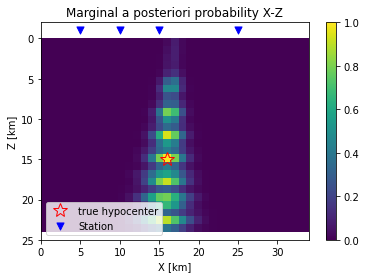

In [8]:
%matplotlib inline

plt.imshow(sigMxz.transpose(), aspect='auto',extent=[space_x[0],space_x[-1],space_z[-1],space_z[0]]
          ,cmap = 'viridis', interpolation='none')
# hiposenter sebenarnya
plt.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')
plt.xlabel("X [km]")
plt.ylabel("Z [km]")
plt.scatter(station_x,station_z-1,marker="v",\
            color="blue",s=50, label="Station")
plt.ylim(max(space_z)+1,-2)
plt.title("Marginal a posteriori probability X-Z")
plt.colorbar()
plt.legend()

Dimana posisi hiposenter dan origin time dengan nilai probabilitas tertinggi?

Kita bisa menggunakan fungsi `np.argmax` dan `np.unravel_index` untuk mendapatkan indeksnya:

In [9]:
max_prob_index=np.unravel_index(sigM.argmax(), sigM.shape)
print(max_prob_index)

(16, 15, 14)


Menggunakan 3 indeks di atas kita dapat mengetahui parameter model dengan nilai probabilitas yang maksimum:

In [10]:
x_prob_max=space_x[max_prob_index[0]]
z_prob_max=space_z[max_prob_index[1]]
T_prob_max=space_T[max_prob_index[2]]
print("Model dengan probabilitas tertinggi:")
print(x_prob_max, z_prob_max,T_prob_max)
print("Model sebenarnya")
print(source_x,source_z,origin_T)

Model dengan probabilitas tertinggi:
16 15 17.0
Model sebenarnya
16 15 17


Selanjutnya kita plot hasil tersebut:

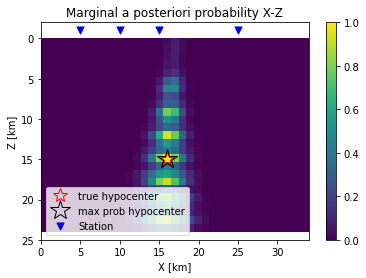

In [11]:
%matplotlib inline

plt.imshow(sigMxz.transpose(), aspect='auto',extent=[space_x[0],space_x[-1],space_z[-1],space_z[0]]
          ,cmap = 'viridis', interpolation='none')
# hiposenter sebenarnya
plt.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')
# hiposenter dengan prob maks
plt.plot(x_prob_max, z_prob_max,'k*', markersize=20,markerfacecolor='None',\
        markeredgewidth=1,label='max prob hypocenter')
plt.xlabel("X [km]")
plt.ylabel("Z [km]")
plt.scatter(station_x,station_z-1,marker="v",\
            color="blue",s=50, label="Station")
plt.ylim(max(space_z)+1,-2)
plt.title("Marginal a posteriori probability X-Z")
plt.colorbar()
plt.legend()

plot untuk $X$,$Y$, dan $T$:

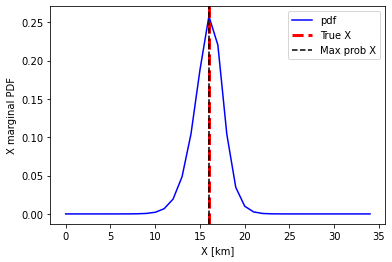

In [12]:
plt.plot(space_x,sigMx,'b-',label='pdf')
plt.axvline(source_x, color="red", linestyle="--", linewidth=3,label="True X")
plt.axvline(x_prob_max, color="black", linestyle="--",label="Max prob X")
plt.xlabel("X [km]")
plt.ylabel("X marginal PDF")
plt.legend()

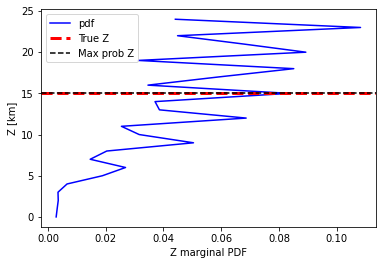

In [13]:
plt.plot(sigMz,space_z,'b-',label='pdf')
plt.axhline(source_z, color="red", linestyle="--", linewidth=3,label="True Z")
plt.axhline(z_prob_max, color="black", linestyle="--",label="Max prob Z")
plt.xlabel("Z marginal PDF")
plt.ylabel("Z [km]")
plt.legend()

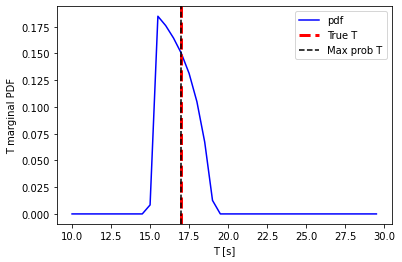

In [14]:
plt.plot(space_T,sigMT,'b-',label='pdf')
plt.axvline(origin_T, color="red", linestyle="--",linewidth=3,label="True T")
plt.axvline(T_prob_max, color="black", linestyle="--",label="Max prob T")
plt.xlabel("T [s]")
plt.ylabel("T marginal PDF")
plt.legend()

menggabungkan plot-plot di atas dengan bantuan `grid`:

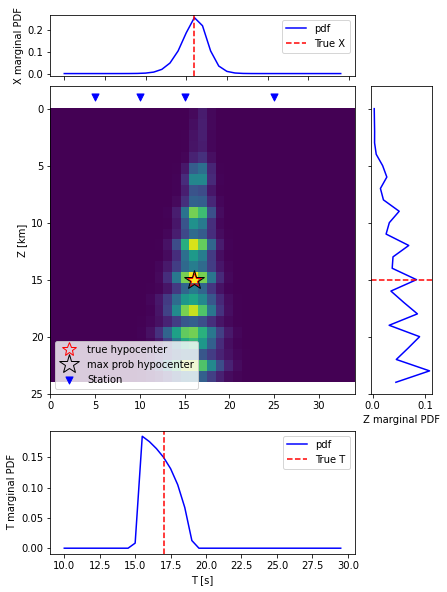

In [17]:
fig1 = plt.figure(figsize=(6, 8), facecolor="white", constrained_layout=True)
gs = fig1.add_gridspec(8, 6)

ax1 = fig1.add_subplot(gs[1:6, :5])
ax2 = fig1.add_subplot(gs[:1, :5])
ax3 = fig1.add_subplot(gs[1:6, 5:6])

ax4 = fig1.add_subplot(gs[6:8, :5])

# X-Z
ax1.imshow(sigMxz.transpose(), aspect='auto',extent=[space_x[0],space_x[-1],space_z[-1],space_z[0]]
          ,cmap = 'viridis', interpolation='none')
# hiposenter sebenarnya
ax1.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')
# hiposenter dengan prob maks
ax1.plot(x_prob_max, z_prob_max,'k*', markersize=20,markerfacecolor='None',\
        markeredgewidth=1,label='max prob hypocenter')
ax1.set_label("X [km]")
ax1.set_ylabel("Z [km]")
ax1.scatter(station_x,station_z-1,marker="v",\
            color="blue",s=50, label="Station")
ax1.set_ylim(max(space_z)+1,-2)
ax1.legend()

# X
ax2.plot(space_x,sigMx,'b-',label='pdf')
ax2.axvline(source_x, color="red", linestyle="--",label="True X")
ax2.set_ylabel("X marginal PDF")
for tl in ax2.get_xticklabels():
    tl.set_visible(False)

ax2.legend()

#Z
ax3.plot(sigMz,space_z,'b-',label='pdf')
ax3.axhline(source_z, color="red", linestyle="--",label="True Z")
ax3.set_xlabel("Z marginal PDF")
ax3.set_ylim(max(space_z),min(space_z))
ax3.set_ylim(max(space_z)+1,-2)
for tl in ax3.get_yticklabels():
    tl.set_visible(False)

#T
ax4.plot(space_T,sigMT,'b-',label='pdf')
ax4.axvline(origin_T, color="red", linestyle="--",label="True T")
ax4.set_xlabel("T [s]")
ax4.set_ylabel("T marginal PDF")
ax4.legend()
#plt.tight_layout()

### Latihan

1. Menggunakan studi kasus serupa di atas tetapi kecepatan tidak eksak sehingga juga akan masuk dalam ruang model tebakan nantinya. Misalkan tebak kecepatan antara 4 sampai 6,5 km/s dengan lompatan 0,25 km/s.

2. Menggunakan studi kasus nomor 2 tetapi priori probability untuk kecepatan dalam bentuk Gaussian dengan rerata 4,5 km/s dan variansnya 1.

# Solusi 1

Memasukkan kecepatan dalam loop

In [18]:
# Ruang model untuk dieksplorasi: (batas bawah, batas atas, lompatan)
space_x = np.arange( 0, 35, 1 )          # koordinat x (km): ( 0, 35, 0.5 )
space_z = np.arange( 0, 25, 1 )          # koordinat z (km): ( 0, 25, 0.5 )
space_T = np.arange(10, 30, 0.5)         # origin time (km): (10, 30, 0.25)
space_v = np.arange( 4,  6.5, 0.25 )     # TAMBAHAN: velocity (km/s): (4, 6.5, 0.25)

from tqdm import tqdm #hanya untuk menampilkan loading bar

# Solusi inversi hiposenter probabilistik
# Membuat matriks seukuran titik-titik ruang model eksplorasi dengan isi 1T
sigM = np.ones([space_x.size, space_z.size, space_T.size, space_v.size]) # TAMBAHAN:1 dimensi, Inisiasi PDF posterior
# Loop pada ruang model
for ix,X in enumerate(tqdm(space_x)): #aplikasikan tqdm agar keluar loading bar
    for iz,Z in enumerate(space_z):
        for it,T in enumerate(space_T):
            for iv,v in enumerate(space_v): #TAMBAHAN
                for istat in range(np.size(station_x)):   # Loop stasiun

                    # Pemodelan maju (forward modelling): TAMBAHAN v_exact diganti v
                    t_calc = T + 1/v * np.sqrt((X-station_x[istat])**2 + (Z-station_z[istat])**2)

                    # Menghitung probabilitas tiap titik model
                    sigM[ix,iz,it,iv] *= np.exp( -(t_calc-t_obs[istat])**2 / (2*uncertain_t[istat]**2))



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.56it/s]


In [19]:
# Menghitung marginal a posteriori probability untuk nilai x dan z
# dan masing-masing untuk x dan z
sigMxz = np.zeros([space_x.size, space_z.size])
sigMz = np.zeros([space_z.size])
sigMx = np.zeros([space_x.size])
for ix in range(space_x.size):
    sigMx[ix] = np.sum(sigM[ix, :, :,:])
    for iz in range(space_z.size):
        sigMz[iz] = np.sum(sigM[:, iz, :,:])
        sigMxz[ix,iz] = np.sum(sigM[ix, iz, :,:])
sigMx /= np.sum(sigMx)
sigMz /= np.sum(sigMz)

# Menghitung marginal a posteriori probability untuk nilai T
sigMT = np.zeros(space_T.size)
for it in range(space_T.size):
    sigMT[it] = np.sum(sigM[:, :, it,:])
sigMT /= np.sum(sigMT)

# Menghitung marginal a posteriori probability untuk nilai v
sigMv = np.zeros(space_v.size)
for iv in range(space_v.size):
    sigMv[iv] = np.sum(sigM[:, :,:,iv])
sigMv /= np.sum(sigMv)

In [20]:
max_prob_index=np.unravel_index(sigM.argmax(), sigM.shape)
x_prob_max=space_x[max_prob_index[0]]
z_prob_max=space_z[max_prob_index[1]]
T_prob_max=space_T[max_prob_index[2]]
v_prob_max=space_v[max_prob_index[3]]

print("Model dengan probabilitas tertinggi:")
print(x_prob_max, z_prob_max,T_prob_max,v_prob_max)
print("Model sebenarnya")
print(source_x,source_z,origin_T, v_exact)

Model dengan probabilitas tertinggi:
16 15 17.0 5.0
Model sebenarnya
16 15 17 5


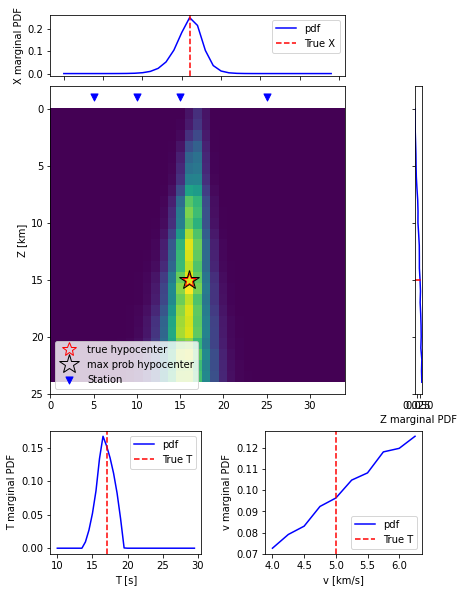

In [21]:
fig1 = plt.figure(figsize=(6, 8), facecolor="white", constrained_layout=True)
gs = fig1.add_gridspec(8, 6)

ax1 = fig1.add_subplot(gs[1:6, :5])
ax2 = fig1.add_subplot(gs[:1, :5])
ax3 = fig1.add_subplot(gs[1:6, 5:6])

# TAMBAHAN axes untuk velocity
ax4 = fig1.add_subplot(gs[6:8, :3])
ax5 = fig1.add_subplot(gs[6:8, 3:6])

# X-Z
ax1.imshow(sigMxz.transpose(), aspect='auto',extent=[space_x[0],space_x[-1],space_z[-1],space_z[0]]
          ,cmap = 'viridis', interpolation='none')
# hiposenter sebenarnya
ax1.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')
# hiposenter dengan prob maks
ax1.plot(x_prob_max, z_prob_max,'k*', markersize=20,markerfacecolor='None',\
        markeredgewidth=1,label='max prob hypocenter')
ax1.set_label("X [km]")
ax1.set_ylabel("Z [km]")
ax1.scatter(station_x,station_z-1,marker="v",\
            color="blue",s=50, label="Station")
ax1.set_ylim(max(space_z)+1,-2)
ax1.legend()

# X
ax2.plot(space_x,sigMx,'b-',label='pdf')
ax2.axvline(source_x, color="red", linestyle="--",label="True X")
ax2.set_ylabel("X marginal PDF")
for tl in ax2.get_xticklabels():
    tl.set_visible(False)

ax2.legend()

#Z
ax3.plot(sigMz,space_z,'b-',label='pdf')
ax3.axhline(source_z, color="red", linestyle="--",label="True Z")
ax3.set_xlabel("Z marginal PDF")
ax3.set_ylim(max(space_z),min(space_z))
ax3.set_ylim(max(space_z)+1,-2)
for tl in ax3.get_yticklabels():
    tl.set_visible(False)

#T
ax4.plot(space_T,sigMT,'b-',label='pdf')
ax4.axvline(origin_T, color="red", linestyle="--",label="True T")
ax4.set_xlabel("T [s]")
ax4.set_ylabel("T marginal PDF")
ax4.legend()

#V TAMBAHAN
ax5.plot(space_v,sigMv,'b-',label='pdf')
ax5.axvline(v_exact, color="red", linestyle="--",label="True T")
ax5.set_xlabel("v [km/s]")
ax5.set_ylabel("v marginal PDF")
ax5.legend()
#plt.tight_layout()

## Solusi 2

In [178]:
#TAMBAHAN 2
v_variance = 1
v_mean=4.5

# Ruang model untuk dieksplorasi: (batas bawah, batas atas, lompatan)
space_x = np.arange( 0, 35, 1 )          # koordinat x (km): ( 0, 35, 0.5 )
space_z = np.arange( 0, 25, 1 )          # koordinat z (km): ( 0, 25, 0.5 )
space_T = np.arange(10, 30, 0.5)         # origin time (km): (10, 30, 0.25)
space_v = np.arange( 4,  6.5, 0.25 )     # TAMBAHAN: velocity (km/s): (4, 6.5, 0.25)

from tqdm import tqdm #hanya untuk menampilkan loading bar

# Solusi inversi hiposenter probabilistik
# Membuat matriks seukuran titik-titik ruang model eksplorasi dengan isi 1T
sigM = np.ones([space_x.size, space_z.size, space_T.size, space_v.size]) # TAMBAHAN 1 dimensi (v), Inisiasi PDF posterior
# Loop pada ruang model
for ix,X in enumerate(tqdm(space_x)): #aplikasikan tqdm agar keluar loading bar
    for iz,Z in enumerate(space_z):
        for it,T in enumerate(space_T):
            for iv,v in enumerate(space_v): #TAMBAHAN
                for istat in range(np.size(station_x)):   # Loop stasiun

                    # Pemodelan maju (forward modelling): TAMBAHAN v_exact diganti v
                    t_calc = T + 1/v * np.sqrt((X-station_x[istat])**2 + (Z-station_z[istat])**2)

                    # Menghitung probabilitas tiap titik model
                    sigM[ix,iz,it,iv] *= np.exp( -(t_calc-t_obs[istat])**2 / (2*uncertain_t[istat]**2))
                #TAMBAHAN untuk 2
                sigM[ix,iz,it,iv] *= np.exp(-(v-v_mean)**2 / (2*v_variance**2))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:13<00:00,  2.61it/s]


In [179]:
# Menghitung marginal a posteriori probability untuk nilai x dan z
# dan masing-masing untuk x dan z
sigMxz = np.zeros([space_x.size, space_z.size])
sigMz = np.zeros([space_z.size])
sigMx = np.zeros([space_x.size])
for ix in range(space_x.size):
    sigMx[ix] = np.sum(sigM[ix, :, :,:])
    for iz in range(space_z.size):
        sigMz[iz] = np.sum(sigM[:, iz, :,:])
        sigMxz[ix,iz] = np.sum(sigM[ix, iz, :,:])
sigMx /= np.sum(sigMx)
sigMz /= np.sum(sigMz)

# Menghitung marginal a posteriori probability untuk nilai T
sigMT = np.zeros(space_T.size)
for it in range(space_T.size):
    sigMT[it] = np.sum(sigM[:, :, it,:])
sigMT /= np.sum(sigMT)

# Menghitung marginal a posteriori probability untuk nilai v
sigMv = np.zeros(space_v.size)
for iv in range(space_v.size):
    sigMv[iv] = np.sum(sigM[:, :,:,iv])
sigMv /= np.sum(sigMv)

# TAMBAHAN 2
# Menghitung priori information untuk v
prior_v = np.zeros(space_v.size)
for iv in range(space_v.size):
    prior_v[iv] = np.exp(-1. / (2*v_variance**2) * ((space_v[0]+iv*(space_v[1]-space_v[0])) - v_mean)**2)
prior_v /= np.sum(prior_v)

In [182]:
max_prob_index=np.unravel_index(sigM.argmax(), sigM.shape)
x_prob_max=space_x[max_prob_index[0]]
z_prob_max=space_z[max_prob_index[1]]
T_prob_max=space_T[max_prob_index[2]]
v_prob_max=space_v[max_prob_index[3]]
print("Model dengan probabilitas tertinggi:")
print(x_prob_max, z_prob_max,T_prob_max,v_prob_max)
print("Model sebenarnya")
print(source_x,source_z,origin_T, v_exact)

Model dengan probabilitas tertinggi:
16 18 16.0 4.5
Model sebenarnya
16 15 17 5


In [181]:
space_v

array([4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 , 5.75, 6.  , 6.25])

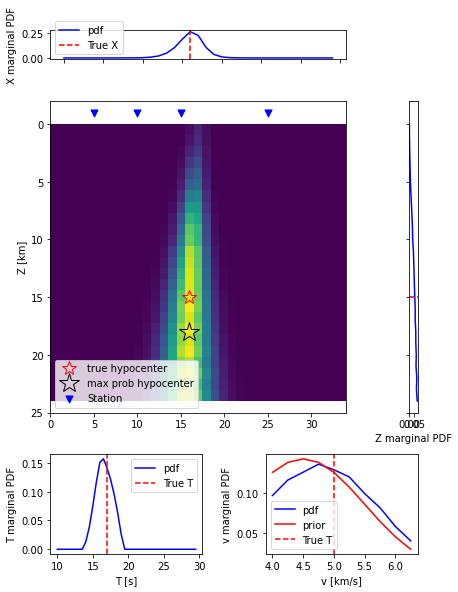

In [176]:
fig1 = plt.figure(figsize=(6, 8), facecolor="white")
gs = fig1.add_gridspec(8, 6)

ax1 = fig1.add_subplot(gs[1:6, :5])
ax2 = fig1.add_subplot(gs[:1, :5])
ax3 = fig1.add_subplot(gs[1:6, 5:6])

# TAMBAHAN axes untuk velocity
ax4 = fig1.add_subplot(gs[6:8, :3])
ax5 = fig1.add_subplot(gs[6:8, 3:6])

# X-Z
ax1.imshow(sigMxz.transpose(), aspect='auto',extent=[space_x[0],space_x[-1],space_z[-1],space_z[0]]
          ,cmap = 'viridis', interpolation='none')
# hiposenter sebenarnya
ax1.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')
# hiposenter dengan prob maks
ax1.plot(x_prob_max, z_prob_max,'k*', markersize=20,markerfacecolor='None',\
        markeredgewidth=1,label='max prob hypocenter')
ax1.set_label("X [km]")
ax1.set_ylabel("Z [km]")
ax1.scatter(station_x,station_z-1,marker="v",\
            color="blue",s=50, label="Station")
ax1.set_ylim(max(space_z)+1,-2)
ax1.legend()

# X
ax2.plot(space_x,sigMx,'b-',label='pdf')
ax2.axvline(source_x, color="red", linestyle="--",label="True X")
ax2.set_ylabel("X marginal PDF")
for tl in ax2.get_xticklabels():
    tl.set_visible(False)

ax2.legend()

#Z
ax3.plot(sigMz,space_z,'b-',label='pdf')
ax3.axhline(source_z, color="red", linestyle="--",label="True Z")
ax3.set_xlabel("Z marginal PDF")
ax3.set_ylim(max(space_z),min(space_z))
ax3.set_ylim(max(space_z)+1,-2)
for tl in ax3.get_yticklabels():
    tl.set_visible(False)

#T
ax4.plot(space_T,sigMT,'b-',label='pdf')
ax4.axvline(origin_T, color="red", linestyle="--",label="True T")
ax4.set_xlabel("T [s]")
ax4.set_ylabel("T marginal PDF")
ax4.legend()

#V TAMBAHAN
ax5.plot(space_v,sigMv,'b-',label='pdf')
ax5.plot(space_v, prior_v, 'r-', label="prior") #TAMBAHAN 2
ax5.axvline(v_exact, color="red", linestyle="--",label="True T")
ax5.set_xlabel("v [km/s]")
ax5.set_ylabel("v marginal PDF")
ax5.legend()
plt.tight_layout()

plot yang lebih rapi

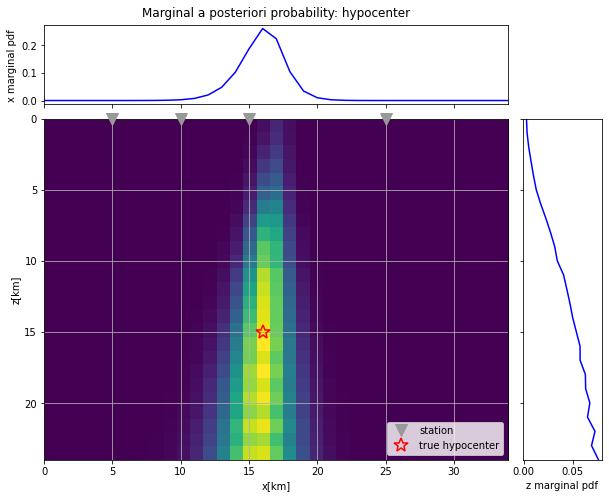

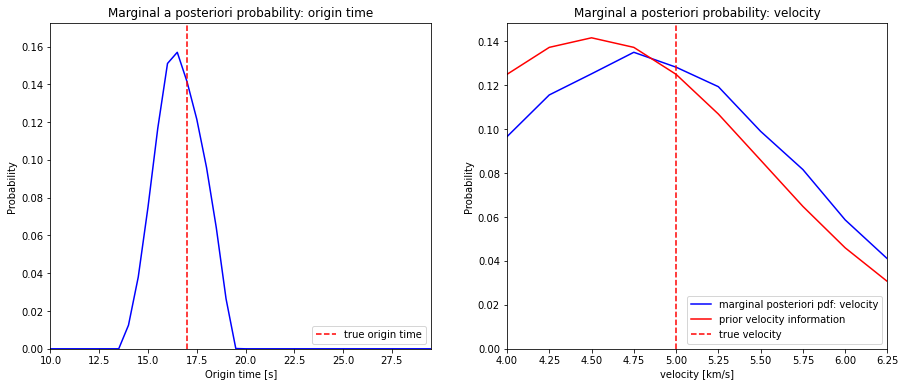

In [161]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
# Plotting the solution of the inverse problem
#----------------

#Plot 2D marginal posteriori pdf for x-z-plane
plt.rcParams['figure.figsize'] = 10,8
f1 = plt.subplot()
f1.plot(station_x, station_z, 'v', color='0.60', markersize=12, clip_on=False, zorder=10, label='station')
f1.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',markeredgewidth=1.5,label='true hypocenter')
f1.imshow(sigMxz.transpose(), aspect='auto',extent=[space_x[0],space_x[-1],space_z[-1],space_z[0]]
          ,cmap = 'viridis', interpolation='none')
f1.set_xlabel('x[km]')
f1.set_ylabel('z[km]')
f1.legend(loc='lower right')
f1.grid()
divider = make_axes_locatable(f1)
fx = divider.append_axes("top", 1.1, pad=0.2, sharex=f1)
fz = divider.append_axes("right", 1.1, pad=0.2, sharey=f1)
fx.set_title('Marginal a posteriori probability: hypocenter',y=1.03)
fx.plot(space_x,sigMx,'b-',label='pdf')
fz.plot(sigMz,space_z,'b-')
fx.set_xlim(space_x[0],space_x[-1])
fz.set_ylim(space_z[-1],space_z[0])
fx.set_ylabel('x marginal pdf')
fz.set_xlabel('z marginal pdf')
for tl in fz.get_yticklabels():
    tl.set_visible(False)
for tl in fx.get_xticklabels():
    tl.set_visible(False)
plt.show()


#Plot marginal posteriori pdf for origin time
plt.rcParams['figure.figsize'] = 15,6
figure = plt.figure()
f2 = figure.add_subplot(121)
f2.plot(space_T, sigMT, 'b-')
f2.plot([origin_T,origin_T],[0,sigMT.max()*1.1],'r--',label='true origin time')
f2.set_xlabel('Origin time [s]')
f2.set_ylabel('Probability')
f2.set_title('Marginal a posteriori probability: origin time')
f2.set_xlim(space_T[0],space_T[-1])
f2.set_ylim(0,sigMT.max()*1.1)
f2.legend(loc='lower right')

#Plot normalized marginal posteriori pdf for velocity
f3 = figure.add_subplot(122)
f3.plot(space_v, sigMv, 'b-',label = 'marginal posteriori pdf: velocity')
f3.plot(space_v, prior_v, 'r-', label='prior velocity information')
f3.plot([v_exact,v_exact],[0,sigMv.max()*1.1],'r--',label='true velocity')
f3.set_xlabel('velocity [km/s]')
f3.set_ylabel('Probability')
f3.set_title('Marginal a posteriori probability: velocity')
f3.set_xlim(space_v[0],space_v[-1])
f3.set_ylim(0,sigMv.max()*1.1)
f3.legend(loc='lower right')

plt.show()

# Referensi

* Igel, H., Geßele K., Seismic Inverse Problems: Probabilistic estimation of earthquake hypocenters, https://krischer.github.io/seismo_live_build/html/Seismic%20Inverse%20Problems/Earthquake%20Location/el_hypocenter_solution_wrapper.html
* Mosegaard, K., & Tarantola, A. (2002). **Probabilistic approach to inverse problems**. International Geophysics Series, 81(A), 237-268.

* Tarantola, A. (2005). **Inverse problem theory and methods for model parameter estimation**. Society for Industrial and Applied Mathematics.